In [4]:
%load_ext autoreload
%autoreload 2

from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from sqlalchemy import event, create_engine, select
from sqlalchemy.orm import sessionmaker

from chemicalite_orm.models import Compound, Base
from chemicalite_orm.molecules import SMILES_SAMPLE as mols
from chemicalite_orm.functions import mol_is_substruct, mol_from_smiles

rdDepictor.SetPreferCoordGen(True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DATABASE_URL = "sqlite:///chemicalite.db"

engine = create_engine(DATABASE_URL, echo=True)


@event.listens_for(engine, "connect")
def load_chemicalite(dbapi_conn, connection_record):
    dbapi_conn.enable_load_extension(True)
    dbapi_conn.load_extension("chemicalite")


SessionLocal = sessionmaker(bind=engine)
Base.metadata.create_all(engine)

2025-05-02 13:39:18,469 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 13:39:18,471 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("compound")
2025-05-02 13:39:18,472 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-02 13:39:18,474 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("compound")
2025-05-02 13:39:18,476 INFO sqlalchemy.engine.Engine [raw sql] ()
2025-05-02 13:39:18,478 INFO sqlalchemy.engine.Engine 
CREATE TABLE compound (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	smiles VARCHAR NOT NULL, 
	molecule mol NOT NULL, 
	PRIMARY KEY (id)
)


2025-05-02 13:39:18,480 INFO sqlalchemy.engine.Engine [no key 0.00195s] ()
2025-05-02 13:39:18,495 INFO sqlalchemy.engine.Engine 
        CREATE VIRTUAL TABLE IF NOT EXISTS str_idx_compound
        USING rdtree(id, fp bits(2048))
    
2025-05-02 13:39:18,497 INFO sqlalchemy.engine.Engine [generated in 0.00257s] ()


2025-05-02 13:39:18,515 INFO sqlalchemy.engine.Engine 
        CREATE VIRTUAL TABLE IF NOT EXISTS sim_idx_compound
        USING rdtree(id, fp bits(1024))
    
2025-05-02 13:39:18,517 INFO sqlalchemy.engine.Engine [generated in 0.00150s] ()
2025-05-02 13:39:18,532 INFO sqlalchemy.engine.Engine COMMIT


In [3]:
def insert_test_data():
    with SessionLocal() as session:
        for i, smiles in enumerate(mols):
            compound = Compound(
                name=f"mol_{i}",
                smiles=smiles,
                molecule=Chem.MolFromSmiles(smiles),
            )
            session.add(compound)
        session.commit()


insert_test_data()

2025-05-02 13:39:40,164 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 13:39:40,169 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-05-02 13:39:40,170 INFO sqlalchemy.engine.Engine [generated in 0.00148s] ('mol_0', 'NN=C(c1ccccc1)c1ccccc1', <memory at 0x7f7a64bbaf40>)
2025-05-02 13:39:40,172 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-05-02 13:39:40,174 INFO sqlalchemy.engine.Engine [cached since 0.004689s ago] ('mol_1', 'COc1ccc(C=NO)cc1', <memory at 0x7f7a64bba880>)
2025-05-02 13:39:40,177 INFO sqlalchemy.engine.Engine INSERT INTO compound (name, smiles, molecule) VALUES (?, ?, mol_from_binary_mol(?))
2025-05-02 13:39:40,178 INFO sqlalchemy.engine.Engine [cached since 0.009042s ago] ('mol_2', 'c1ccc(C(=NC(c2ccccc2)c2ccccc2)c2ccccc2)cc1', <memory at 0x7f7a64bbaf40>)
2025-05-02 13:39:40,180 INFO sqlalchemy.engine.Engine INSERT INTO

2025-05-02 13:42:15,589 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 13:42:15,590 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_binary_mol(compound.molecule) AS molecule 
FROM compound 
WHERE mol_is_substruct(compound.molecule, mol_from_smiles(?))
2025-05-02 13:42:15,591 INFO sqlalchemy.engine.Engine [cached since 13.69s ago] ('c1ccccc1',)
2025-05-02 13:42:15,597 INFO sqlalchemy.engine.Engine ROLLBACK


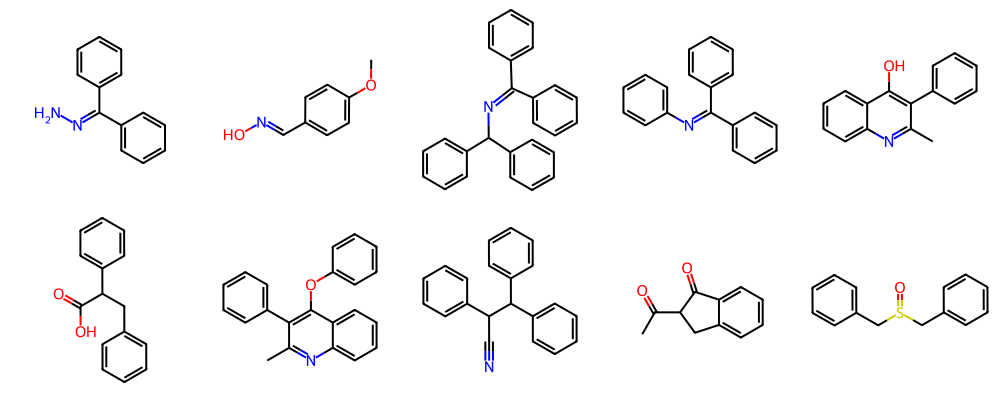

In [6]:
def test_substructure(smarts="c1ccccc1"):
    query_mol = mol_from_smiles(smarts)
    with SessionLocal() as session:
        stmt = select(Compound).where(mol_is_substruct(Compound.molecule, query_mol))
        results = session.execute(stmt).scalars().all()
        mols = [r.molecule for r in results]
    return mols


res_mols = test_substructure()
Draw.MolsToGridImage(res_mols[:10], molsPerRow=5)

2025-05-02 13:49:30,399 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 13:49:30,402 INFO sqlalchemy.engine.Engine SELECT compound.id, compound.name, compound.smiles, mol_to_binary_mol(compound.molecule) AS molecule 
FROM compound 
WHERE compound.name = ?
2025-05-02 13:49:30,404 INFO sqlalchemy.engine.Engine [generated in 0.00183s] ('mol_1',)
2025-05-02 13:49:30,408 INFO sqlalchemy.engine.Engine ROLLBACK


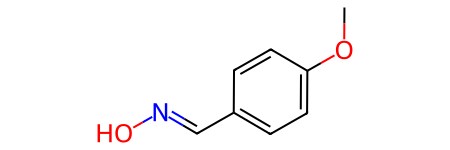

In [14]:
def test_search():
    with SessionLocal() as session:
        stmt = select(Compound).where(Compound.name == "mol_1")
        result = session.execute(stmt).scalars().first()
        mol = result.molecule

    return mol


test_search()

2025-05-02 13:46:05,510 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 13:46:05,513 INFO sqlalchemy.engine.Engine 
            SELECT compound.* FROM compound
            JOIN str_idx_compound ON compound.id = str_idx_compound.id
            WHERE str_idx_compound.id MATCH rdtree_subset(mol_pattern_bfp(mol_from_smiles(?), 2048));
        
2025-05-02 13:46:05,515 INFO sqlalchemy.engine.Engine [cached since 182.2s ago] ('c1ccnnc1',)


1
2025-05-02 13:46:05,520 INFO sqlalchemy.engine.Engine ROLLBACK


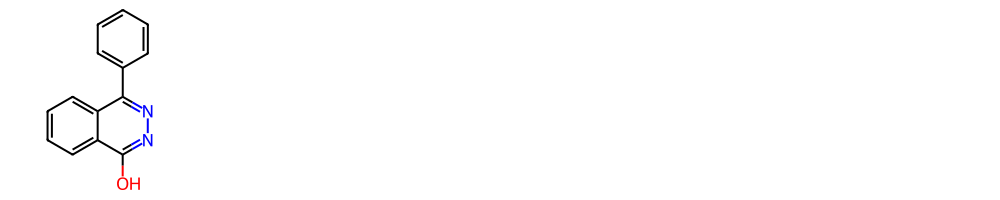

In [10]:
with SessionLocal() as session:
    hits = Compound.search_by_substructure(session, "c1ccnnc1")
    print(len(hits))
    

hit_smis = [hit.smiles for hit in hits]
hit_mols = [Chem.MolFromSmiles(smi) for smi in hit_smis[:10]]
Draw.MolsToGridImage(hit_mols, molsPerRow=5)


2025-05-02 13:46:12,706 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2025-05-02 13:46:12,708 INFO sqlalchemy.engine.Engine 
            SELECT compound.*, bfp_tanimoto(sim_idx_compound.fp, mol_morgan_bfp(mol_from_smiles(?), 2, 1024)) as sim
            FROM compound
            JOIN sim_idx_compound ON compound.id = sim_idx_compound.id
            WHERE sim >= ?
            ORDER BY sim DESC
        
2025-05-02 13:46:12,709 INFO sqlalchemy.engine.Engine [generated in 0.00159s] ('c1ccnnc1', 0.01)
76
2025-05-02 13:46:12,713 INFO sqlalchemy.engine.Engine ROLLBACK


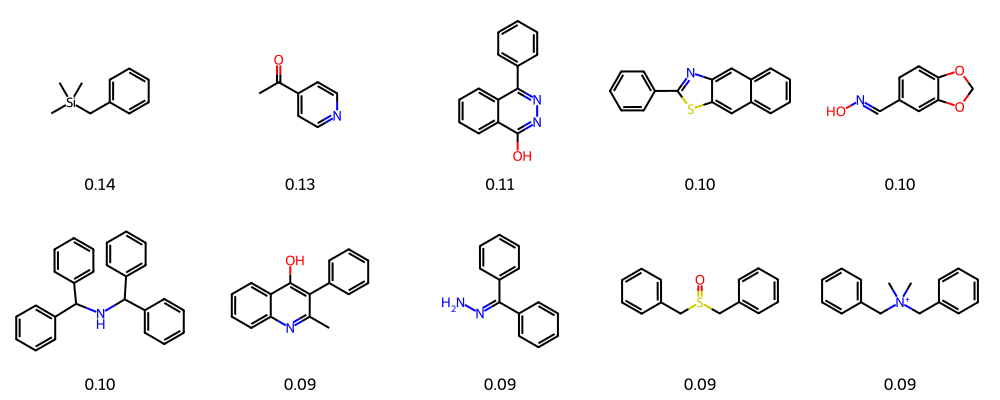

In [11]:
with SessionLocal() as session:
    hits = Compound.search_by_similarity(session, "c1ccnnc1", 0.01)
    print(len(hits))


hit_smis = [hit.smiles for hit in hits[:10]]
hit_mols = [Chem.MolFromSmiles(smi) for smi in hit_smis]
similarity = [hit.sim for hit in hits[:10]]
Draw.MolsToGridImage(
    hit_mols, molsPerRow=5, legends=[f"{s:.2f}" for s in similarity]
)
